## 最终预测数据输出：
### 使用全量数据，因train.csv最后六周数据理论上对测试集销量的相关性应大于更早的时间，故也尝试将其加入到训练集中，以争取最终输出更高的Kaggle分数

In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from scipy import stats
import datetime
import random

/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


-----
## 读取文件（在特征工程后生成的数据）

In [2]:
all_df = pd.read_csv("model_data0317_ext.csv")
all_df.head()

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SalesLog,SchoolHoliday,Set,...,avgsal_last3m,avgsal_last6m,avgsal_mblm,avgsal_percustomer,avgsal_std,daysFromLastSchHol,daysFromLastStateHol,daysToNextSchHol,daysToNextStateHol,Outlier
0,678.0,2013-03-02,6,NaN,1.0,0,5350.0,8.585039,0,1,...,8.530299,8.530299,8.505253,8.155622,6.696062,50.0,60.0,23.0,27.0,0
1,840.0,2013-03-04,1,NaN,1.0,1,7675.0,8.945854,0,1,...,8.531381,8.531381,8.505253,8.150073,6.687390,52.0,62.0,21.0,25.0,1
2,715.0,2013-03-05,2,NaN,1.0,1,6300.0,8.748464,0,1,...,8.541024,8.541024,8.505253,8.175047,6.770112,53.0,63.0,20.0,24.0,0
3,678.0,2013-03-06,3,NaN,1.0,1,5973.0,8.695172,0,1,...,8.545284,8.545284,8.505253,8.188462,6.777641,54.0,64.0,19.0,23.0,0
4,702.0,2013-03-07,4,NaN,1.0,1,5637.0,8.637285,0,1,...,8.548220,8.548220,8.505253,8.200642,6.776555,55.0,65.0,18.0,22.0,0


In [3]:
all_df['Date'] = pd.to_datetime(all_df['Date'])
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639411 entries, 0 to 639410
Data columns (total 58 columns):
Customers                    598323 non-null float64
Date                         639411 non-null datetime64[ns]
DayOfWeek                    639411 non-null int64
Id                           41088 non-null float64
Open                         639411 non-null float64
Promo                        639411 non-null int64
Sales                        598323 non-null float64
SalesLog                     598323 non-null float64
SchoolHoliday                639411 non-null int64
Set                          639411 non-null int64
StateHoliday                 639411 non-null int64
Store                        639411 non-null int64
Year                         639411 non-null int64
MonthofYear                  639411 non-null int64
WeekofYear                   639411 non-null int64
DayofMonth                   639411 non-null int64
DayofYear                    639411 non-null int64
Date

-----
## 定义评估函数 rmspe

In [4]:
def rmspe(y, yhat):
    # rmspe 计算
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    # xgboost 中对 rmspe 参数赋值
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

def exp_transform(x):
    return np.expm1(x)

-----
## 选取参与训练的特征，划分训练数据和验证数据

In [5]:
y_col = 'SalesLog'
x_cols =  [ 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday', 'Store',
            'MonthofYear', 'WeekofYear', 'DayofMonth', 'DayofYear', 'DateInt',
            'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2',
            'Promo2SinceFloat', 'CompetitionOpenInt', 'sal_avg',
            'sal_avg_percustomer', 'sal_avg_promo', 'sal_avg_schoolhol',
            'sal_avg_statehol', 'sal_avg_std', 'CompetitionLastMonths',
            'inCompetition', 'Promo2LastMonths', 'Promo2_Month', 'inPromo2',
            'PromoIntervalType', 'avgsal', 'avgsal_curryear', 'avgsal_dayofmonth',
            'avgsal_dayofmonth_res', 'avgsal_dayofweek', 'avgsal_dayofweek_res',
            'avgsal_dayofyear', 'avgsal_last3m', 'avgsal_last6m', 'avgsal_mblm',
            'avgsal_percustomer', 'avgsal_std', 'daysFromLastSchHol',
            'daysFromLastStateHol', 'daysToNextSchHol', 'daysToNextStateHol']
train_data = all_df[(all_df['Set']==1) & (all_df['Outlier']==0)] #[x_cols+[y_col]]
#test_data = all_df[all_df['Set']==2]#[x_cols+[y_col]]
print(len(train_data))
X_train, X_test, y_train, y_test = train_test_split(train_data[x_cols],
                                                    train_data[y_col],
                                                    test_size=0.1,
                                                    random_state=42)

586890


-----
## 定义网格搜索函数，用来确定模型的最优参数

In [6]:
def tune_gridsearch(model,param_dict,X_train, X_test, y_train, y_test):
    clf = GridSearchCV(model,
                       param_dict,
                       n_jobs=36,
                       iid=False,
                       cv=5,
                       verbose=1
                      )
    clf.fit(X_train,y_train)
    xgb_best = clf.best_estimator_
    print("xgb train MSE: %.4f" % mean_squared_error(y_train, xgb_best.predict(X_train)))
    print("xgb test MSE: %.4f" % mean_squared_error(y_test, xgb_best.predict(X_test)))
    display(clf.grid_scores_)
    print(clf.best_params_)
    print(clf.best_score_)
    return clf.best_estimator_

from sklearn.metrics import mean_squared_error

-----
## 因数据量大，时间原因，仅抽样少量数据进行网格搜索

In [7]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_test,
                                                    y_test,
                                                    test_size=0.2,
                                                    random_state=42)

len(y_train1),len(y_test1)
#xgb_model = XGBRegressor(random_state=10)
#param_dict = {'max_depth':[i for i in range(11,19,2)],
#              'min_child_weight':[i for i in range(11,19,2)]}
#best_model = tune_gridsearch(xgb_model,param_dict,X_train1, X_test1, y_train1, y_test1)

(46951, 11738)

-----
### 开始网格搜索，主要优化参数：
* max_depth
* min_child_weight
* gamma
* subsample
* colsample_bytree
* reg_lambda
* reg_alpha

In [8]:
xgb_model = XGBRegressor(random_state=10)
param_dict = {'max_depth':[10,11,12,13,14],
              'min_child_weight':[10,15,20,25,30]}
best_model = tune_gridsearch(xgb_model,param_dict,X_train1, X_test1, y_train1, y_test1)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=36)]: Done 125 out of 125 | elapsed:  1.4min finished


xgb train MSE: 0.0034
xgb test MSE: 0.0094


[mean: 0.93495, std: 0.00101, params: {'max_depth': 10, 'min_child_weight': 10},
 mean: 0.93467, std: 0.00093, params: {'max_depth': 10, 'min_child_weight': 15},
 mean: 0.93434, std: 0.00119, params: {'max_depth': 10, 'min_child_weight': 20},
 mean: 0.93371, std: 0.00088, params: {'max_depth': 10, 'min_child_weight': 25},
 mean: 0.93310, std: 0.00154, params: {'max_depth': 10, 'min_child_weight': 30},
 mean: 0.93584, std: 0.00088, params: {'max_depth': 11, 'min_child_weight': 10},
 mean: 0.93551, std: 0.00098, params: {'max_depth': 11, 'min_child_weight': 15},
 mean: 0.93524, std: 0.00140, params: {'max_depth': 11, 'min_child_weight': 20},
 mean: 0.93433, std: 0.00096, params: {'max_depth': 11, 'min_child_weight': 25},
 mean: 0.93411, std: 0.00140, params: {'max_depth': 11, 'min_child_weight': 30},
 mean: 0.93580, std: 0.00102, params: {'max_depth': 12, 'min_child_weight': 10},
 mean: 0.93582, std: 0.00132, params: {'max_depth': 12, 'min_child_weight': 15},
 mean: 0.93525, std: 0.00087

{'max_depth': 14, 'min_child_weight': 15}
0.936418091513709


In [9]:
param_dict = {'gamma':[i/10.0 for i in range(0,11)]}
best_model = tune_gridsearch(best_model,param_dict,X_train1, X_test1, y_train1, y_test1)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=36)]: Done  40 out of  55 | elapsed:   50.2s remaining:   18.8s
[Parallel(n_jobs=36)]: Done  55 out of  55 | elapsed:   52.6s finished


xgb train MSE: 0.0034
xgb test MSE: 0.0094


[mean: 0.93642, std: 0.00116, params: {'gamma': 0.0},
 mean: 0.93424, std: 0.00130, params: {'gamma': 0.1},
 mean: 0.93104, std: 0.00098, params: {'gamma': 0.2},
 mean: 0.92796, std: 0.00168, params: {'gamma': 0.3},
 mean: 0.92508, std: 0.00150, params: {'gamma': 0.4},
 mean: 0.92314, std: 0.00170, params: {'gamma': 0.5},
 mean: 0.92098, std: 0.00074, params: {'gamma': 0.6},
 mean: 0.91878, std: 0.00113, params: {'gamma': 0.7},
 mean: 0.91635, std: 0.00166, params: {'gamma': 0.8},
 mean: 0.91570, std: 0.00124, params: {'gamma': 0.9},
 mean: 0.91290, std: 0.00233, params: {'gamma': 1.0}]

{'gamma': 0.0}
0.936418091513709


In [10]:
param_dict = {'subsample':[i/10.0 for i in range(6,10)],
              'colsample_bytree':[i/10.0 for i in range(6,10)]}
best_model = tune_gridsearch(best_model,param_dict,X_train1, X_test1, y_train1, y_test1)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=36)]: Done  80 out of  80 | elapsed:  1.0min finished


xgb train MSE: 0.0032
xgb test MSE: 0.0095


[mean: 0.93506, std: 0.00090, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
 mean: 0.93619, std: 0.00079, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
 mean: 0.93649, std: 0.00076, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
 mean: 0.93711, std: 0.00090, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
 mean: 0.93518, std: 0.00094, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
 mean: 0.93581, std: 0.00100, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
 mean: 0.93657, std: 0.00086, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
 mean: 0.93730, std: 0.00095, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
 mean: 0.93498, std: 0.00112, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
 mean: 0.93564, std: 0.00103, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
 mean: 0.93598, std: 0.00108, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
 mean: 0.93664, std: 0.00120, params: {'colsample_bytree': 0.8, 'subsample': 0.9},
 mea

{'colsample_bytree': 0.7, 'subsample': 0.9}
0.9373009447839917


In [11]:
param_dict = {'subsample':[i/100.0 for i in range(80,100,5)],
              'colsample_bytree':[i/100.0 for i in range(65,80,5)]}
best_model = tune_gridsearch(best_model,param_dict,X_train1, X_test1, y_train1, y_test1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=36)]: Done  50 out of  60 | elapsed:   36.8s remaining:    7.4s
[Parallel(n_jobs=36)]: Done  60 out of  60 | elapsed:   37.8s finished


xgb train MSE: 0.0032
xgb test MSE: 0.0095


[mean: 0.93691, std: 0.00057, params: {'colsample_bytree': 0.65, 'subsample': 0.8},
 mean: 0.93721, std: 0.00121, params: {'colsample_bytree': 0.65, 'subsample': 0.85},
 mean: 0.93724, std: 0.00074, params: {'colsample_bytree': 0.65, 'subsample': 0.9},
 mean: 0.93713, std: 0.00093, params: {'colsample_bytree': 0.65, 'subsample': 0.95},
 mean: 0.93657, std: 0.00086, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
 mean: 0.93708, std: 0.00100, params: {'colsample_bytree': 0.7, 'subsample': 0.85},
 mean: 0.93730, std: 0.00095, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
 mean: 0.93718, std: 0.00093, params: {'colsample_bytree': 0.7, 'subsample': 0.95},
 mean: 0.93637, std: 0.00088, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
 mean: 0.93699, std: 0.00115, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
 mean: 0.93669, std: 0.00109, params: {'colsample_bytree': 0.75, 'subsample': 0.9},
 mean: 0.93718, std: 0.00092, params: {'colsample_bytree': 0.75, 'subsample

{'colsample_bytree': 0.7, 'subsample': 0.9}
0.9373009447839917


In [12]:
param_dict = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
best_model = tune_gridsearch(best_model,param_dict,X_train1, X_test1, y_train1, y_test1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=36)]: Done   6 out of  25 | elapsed:   19.4s remaining:  1.0min
[Parallel(n_jobs=36)]: Done  25 out of  25 | elapsed:   20.5s finished


xgb train MSE: 0.0032
xgb test MSE: 0.0095


[mean: 0.93740, std: 0.00080, params: {'reg_alpha': 1e-05},
 mean: 0.93735, std: 0.00080, params: {'reg_alpha': 0.01},
 mean: 0.93724, std: 0.00097, params: {'reg_alpha': 0.1},
 mean: 0.93579, std: 0.00102, params: {'reg_alpha': 1},
 mean: 0.88461, std: 0.00128, params: {'reg_alpha': 100}]

{'reg_alpha': 1e-05}
0.9373994802497977


In [13]:
param_dict = {'reg_alpha':[0,1e-6,1e-5,1e-4,1e-3]}#[0.005,0.01,0.015,0.02,0.025]}
best_model = tune_gridsearch(best_model,param_dict,X_train1, X_test1, y_train1, y_test1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=36)]: Done   6 out of  25 | elapsed:   19.6s remaining:  1.0min
[Parallel(n_jobs=36)]: Done  25 out of  25 | elapsed:   21.0s finished


xgb train MSE: 0.0033
xgb test MSE: 0.0095


[mean: 0.93730, std: 0.00095, params: {'reg_alpha': 0},
 mean: 0.93729, std: 0.00093, params: {'reg_alpha': 1e-06},
 mean: 0.93740, std: 0.00080, params: {'reg_alpha': 1e-05},
 mean: 0.93721, std: 0.00074, params: {'reg_alpha': 0.0001},
 mean: 0.93749, std: 0.00073, params: {'reg_alpha': 0.001}]

{'reg_alpha': 0.001}
0.9374871361842969


In [14]:
param_dict = {'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]}
best_model = tune_gridsearch(best_model,param_dict,X_train1, X_test1, y_train1, y_test1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=36)]: Done   6 out of  25 | elapsed:   20.0s remaining:  1.1min
[Parallel(n_jobs=36)]: Done  25 out of  25 | elapsed:   23.5s finished


xgb train MSE: 0.0033
xgb test MSE: 0.0095


[mean: 0.92991, std: 0.00137, params: {'reg_lambda': 1e-05},
 mean: 0.93241, std: 0.00113, params: {'reg_lambda': 0.01},
 mean: 0.93565, std: 0.00069, params: {'reg_lambda': 0.1},
 mean: 0.93749, std: 0.00073, params: {'reg_lambda': 1},
 mean: 0.93041, std: 0.00111, params: {'reg_lambda': 100}]

{'reg_lambda': 1}
0.9374871361842969


In [15]:
param_dict = {'reg_lambda':[0.5,1,2,5,10,50]}
best_model = tune_gridsearch(best_model,param_dict,X_train1, X_test1, y_train1, y_test1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=36)]: Done  21 out of  30 | elapsed:   20.0s remaining:    8.6s
[Parallel(n_jobs=36)]: Done  30 out of  30 | elapsed:   20.7s finished


xgb train MSE: 0.0033
xgb test MSE: 0.0095


[mean: 0.93693, std: 0.00085, params: {'reg_lambda': 0.5},
 mean: 0.93749, std: 0.00073, params: {'reg_lambda': 1},
 mean: 0.93712, std: 0.00088, params: {'reg_lambda': 2},
 mean: 0.93654, std: 0.00076, params: {'reg_lambda': 5},
 mean: 0.93594, std: 0.00076, params: {'reg_lambda': 10},
 mean: 0.93329, std: 0.00100, params: {'reg_lambda': 50}]

{'reg_lambda': 1}
0.9374871361842969


In [16]:
best_model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.7,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 14,
 'min_child_weight': 15,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0.001,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 10,
 'silent': 1,
 'subsample': 0.9}

In [17]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=14, min_child_weight=15, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=10, reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

-----
## 正式训练，使用网格搜索优化过的参数

In [18]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]

params = {'base_score': 0.5,
             'booster': 'gbtree',
             'colsample_bylevel': 1,
             'colsample_bytree': 0.7,
             'gamma': 0.0,
             'eta': 0.01,
             'max_delta_step': 0,
             'max_depth': 14,
             'min_child_weight': 15,
             'missing': None,
             'n_estimators': 20000,
             'nthread': 16,
             'objective': 'reg:linear',
             'reg_alpha': 0.001,
             'reg_lambda': 1,
             'scale_pos_weight': 1,
             'seed': 10,
             'silent': 1,
             'subsample': 0.9}

bst1 = xgb.train(params, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

[0]	train-rmse:8.17371	test-rmse:8.17336	train-rmspe:0.999865	test-rmspe:0.999864
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.
[250]	train-rmse:0.672555	test-rmse:0.672365	train-rmspe:0.485152	test-rmspe:0.484971
[500]	train-rmse:0.098439	test-rmse:0.104891	train-rmspe:0.095344	test-rmspe:0.10371
[750]	train-rmse:0.07125	test-rmse:0.083805	train-rmspe:0.073573	test-rmspe:0.089834
[1000]	train-rmse:0.065472	test-rmse:0.081313	train-rmspe:0.067651	test-rmspe:0.08777
[1250]	train-rmse:0.062351	test-rmse:0.08026	train-rmspe:0.064249	test-rmspe:0.086699
[1500]	train-rmse:0.060448	test-rmse:0.079717	train-rmspe:0.062188	test-rmspe:0.086149
[1750]	train-rmse:0.058774	test-rmse:0.079316	train-rmspe:0.060389	test-rmspe:0.085748
[2000]	train-rmse:0.057338	test-rmse:0.079033	train-rmspe:0.05884	test-rmspe:0.085447
[2250]	train-rmse:0.056087	test-rmse:0.078822	train-rmspe:0.057489	test-rmspe:0.0852

-----
### 预测数据

In [19]:
test_data = all_df[all_df['Set']==2].sort_values('Id')
dsubmit = xgb.DMatrix(test_data[x_cols])
ypred_bst = bst1.predict(dsubmit)
ypred_bst

array([ 8.45646954,  8.9920311 ,  9.17390823, ...,  8.68684101,
        9.97959518,  8.85672855], dtype=float32)

In [20]:
#test_data = test_data.sort_values('Id')
test_data['Id'] = test_data['Id'].astype(int)
test_data['Sales'] = (np.expm1(ypred_bst)).astype(int)
test_data[['Id','Sales']].to_csv('submission.csv', index=False)

-----
### 特征重要性排行

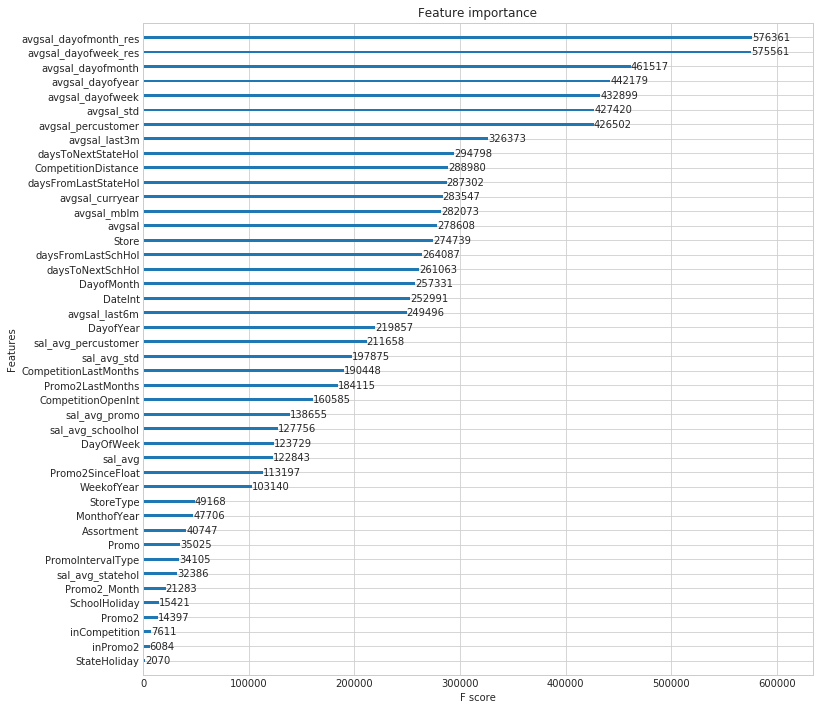

In [21]:
fig,ax=plt.subplots(figsize=(12,12))
xgb.plot_importance(bst1,ax=ax)

-----
### 提交预测到 Kaggle，保存模型

In [22]:
!kaggle competitions submit -c rossmann-store-sales -f submission.csv -m "MessageNSC"

Successfully submitted to Rossmann Store Sales

In [23]:
test_data['Sales'] = (np.expm1(ypred_bst)*0.97).astype(int)
test_data[['Id','Sales']].to_csv('submission.csv', index=False)

In [24]:
!kaggle competitions submit -c rossmann-store-sales -f submission.csv -m "0318SC097-d12-09-07"

Successfully submitted to Rossmann Store Sales

In [ ]:
from sklearn.externals import joblib
joblib.dump(bst1, "model_xgb1.m")